In [1]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/trainer.py --output trainer.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/classification_models.py --output classification_models.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/classification_models2.py --output classification_models2.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/classification_models3.py --output classification_models3.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/compare-models/classification_models4.py --output classification_models4.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0   3216      0 --:--:-- --:--:-- --:--:--  3216
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0  21574      0 --:--:-- --:--:-- --:--:-- 21467
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4266  100  4266    0     0  19568      0 --:--:-- --:--:-- --:--:-- 19568
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3952  100  3952    0     0  21021      0 --:--:-- --:--:-- --:--:-- 21021
  % Total    % Received % Xferd  Average Speed   Tim

## Import modules

In [2]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
from classification_models import DeeperModelWithSELU
from classification_models2 import HighParamCnnWithSELU
from classification_models3 import CNNWithFiveLayerLeakyReLU
from classification_models4 import MultiLayerSeLU
from trainer import Trainer, ModelCheckpoint          # Trainer Class

## Preprocessing Dataset | (from .mat to .npy)

Download and unzip dataset

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

Convert .mat to .npy

In [4]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

Save labels in a CSV file

In [5]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

Remove MAT files

In [6]:
!rm -rf tmp_dataset

## Functions Tools

In [7]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

## Config GPU and Seed

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [9]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

## Load Dataset and Create DataLoaders

In [10]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [11]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [12]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


## View Dataset

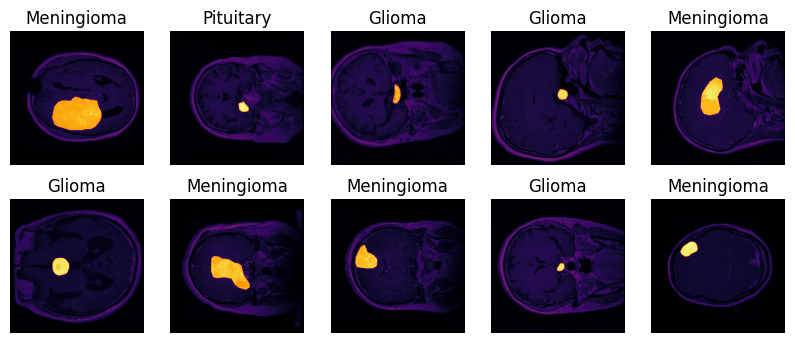

In [13]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

### Training

In [14]:
model = DeeperModelWithSELU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
deeper_model_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]



Epoch (1/10): train_loss = 0.861096, val_loss= 0.000591, train_acc = 0.642974, val_acc= 0.770492

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:09<00:00,  2.14it/s]



Epoch (2/10): train_loss = 0.476688, val_loss= 0.000094, train_acc = 0.817933, val_acc= 0.880328

val_loss changed (0.000591 -> 0.000094). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.91it/s]



Epoch (3/10): train_loss = 0.313956, val_loss= 0.000027, train_acc = 0.886277, val_acc= 0.885246

val_loss changed (0.000094 -> 0.000027). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.31it/s]



Epoch (4/10): train_loss = 0.280423, val_loss= 0.000060, train_acc = 0.893384, val_acc= 0.883607



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.55it/s]



Epoch (5/10): train_loss = 0.283624, val_loss= 0.000136, train_acc = 0.894478, val_acc= 0.913115



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.30it/s]



Epoch (6/10): train_loss = 0.232224, val_loss= 0.000045, train_acc = 0.913614, val_acc= 0.896721



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.66it/s]



Epoch (7/10): train_loss = 0.195382, val_loss= 0.000013, train_acc = 0.926736, val_acc= 0.932787

val_loss changed (0.000027 -> 0.000013). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.41it/s]



Epoch (8/10): train_loss = 0.225898, val_loss= 0.000091, train_acc = 0.920175, val_acc= 0.931148



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.86it/s]



Epoch (9/10): train_loss = 0.169623, val_loss= 0.000028, train_acc = 0.937671, val_acc= 0.950820



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.00it/s]


Epoch (10/10): train_loss = 0.148548, val_loss= 0.000039, train_acc = 0.950793, val_acc= 0.950820



In [19]:
model = HighParamCnnWithSELU()
optimizer = optim.Adam(model.parameters(), 0.001)

epochs = 10
high_param_cnn_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.92it/s]



Epoch (1/10): train_loss = 0.935489, val_loss= 0.001386, train_acc = 0.566430, val_acc= 0.768852

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]



Epoch (2/10): train_loss = 0.510206, val_loss= 0.000213, train_acc = 0.781301, val_acc= 0.781967

val_loss changed (0.001386 -> 0.000213). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.06it/s]



Epoch (3/10): train_loss = 0.366490, val_loss= 0.001455, train_acc = 0.842537, val_acc= 0.903279



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s]



Epoch (4/10): train_loss = 0.309611, val_loss= 0.004409, train_acc = 0.874795, val_acc= 0.827869



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.95it/s]



Epoch (5/10): train_loss = 0.239477, val_loss= 0.001732, train_acc = 0.907600, val_acc= 0.936066



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.70it/s]



Epoch (6/10): train_loss = 0.181311, val_loss= 0.000960, train_acc = 0.934937, val_acc= 0.934426



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.53it/s]



Epoch (7/10): train_loss = 0.148320, val_loss= 0.000005, train_acc = 0.939311, val_acc= 0.916393

val_loss changed (0.000213 -> 0.000005). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.90it/s]



Epoch (8/10): train_loss = 0.134148, val_loss= 0.000060, train_acc = 0.955167, val_acc= 0.947541



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.32it/s]



Epoch (9/10): train_loss = 0.149518, val_loss= 0.000185, train_acc = 0.946419, val_acc= 0.937705



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch (10/10): train_loss = 0.119192, val_loss= 0.003766, train_acc = 0.958447, val_acc= 0.913115



In [16]:
model = CNNWithFiveLayerLeakyReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
cnn_with_five_layer_leakyrelu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.54it/s]



Epoch (1/10): train_loss = 0.842623, val_loss= 0.001572, train_acc = 0.576818, val_acc= 0.663934

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.87it/s]



Epoch (2/10): train_loss = 0.764088, val_loss= 0.001295, train_acc = 0.628212, val_acc= 0.626230

val_loss changed (0.001572 -> 0.001295). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.71it/s]



Epoch (3/10): train_loss = 0.746270, val_loss= 0.001483, train_acc = 0.630946, val_acc= 0.650820



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.69it/s]



Epoch (4/10): train_loss = 0.693009, val_loss= 0.001182, train_acc = 0.668125, val_acc= 0.657377

val_loss changed (0.001295 -> 0.001182). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.25it/s]



Epoch (5/10): train_loss = 0.717935, val_loss= 0.001621, train_acc = 0.664297, val_acc= 0.672131



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.56it/s]



Epoch (6/10): train_loss = 0.645446, val_loss= 0.000216, train_acc = 0.696009, val_acc= 0.798361

val_loss changed (0.001182 -> 0.000216). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.89it/s]



Epoch (7/10): train_loss = 0.574455, val_loss= 0.000008, train_acc = 0.761072, val_acc= 0.754098

val_loss changed (0.000216 -> 0.000008). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.68it/s]



Epoch (8/10): train_loss = 0.454851, val_loss= 0.000001, train_acc = 0.832695, val_acc= 0.875410

val_loss changed (0.000008 -> 0.000001). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.66it/s]



Epoch (9/10): train_loss = 0.428862, val_loss= 0.000100, train_acc = 0.838710, val_acc= 0.845902



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.84it/s]


Epoch (10/10): train_loss = 0.317596, val_loss= 0.000004, train_acc = 0.883543, val_acc= 0.919672



In [17]:
model = MultiLayerSeLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
multilayer_with_selu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s]



Epoch (1/10): train_loss = 60.030404, val_loss= 0.004345, train_acc = 0.453800, val_acc= 0.629508

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.75it/s]



Epoch (2/10): train_loss = 0.943533, val_loss= 0.003638, train_acc = 0.598688, val_acc= 0.516393

val_loss changed (0.004345 -> 0.003638). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.79it/s]



Epoch (3/10): train_loss = 0.776878, val_loss= 0.009655, train_acc = 0.662110, val_acc= 0.480328



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.72it/s]



Epoch (4/10): train_loss = 0.689571, val_loss= 0.002739, train_acc = 0.709677, val_acc= 0.740984

val_loss changed (0.003638 -> 0.002739). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.94it/s]



Epoch (5/10): train_loss = 0.579933, val_loss= 0.000413, train_acc = 0.754511, val_acc= 0.809836

val_loss changed (0.002739 -> 0.000413). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.74it/s]



Epoch (6/10): train_loss = 0.561149, val_loss= 0.000824, train_acc = 0.768179, val_acc= 0.793443



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.70it/s]



Epoch (7/10): train_loss = 0.479664, val_loss= 0.000540, train_acc = 0.813013, val_acc= 0.824590



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.28it/s]



Epoch (8/10): train_loss = 0.497181, val_loss= 0.000254, train_acc = 0.805905, val_acc= 0.808197

val_loss changed (0.000413 -> 0.000254). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s]



Epoch (9/10): train_loss = 0.472830, val_loss= 0.000317, train_acc = 0.819574, val_acc= 0.822951



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.66it/s]


Epoch (10/10): train_loss = 0.478125, val_loss= 0.000713, train_acc = 0.829415, val_acc= 0.865574



<ipython-input-7-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


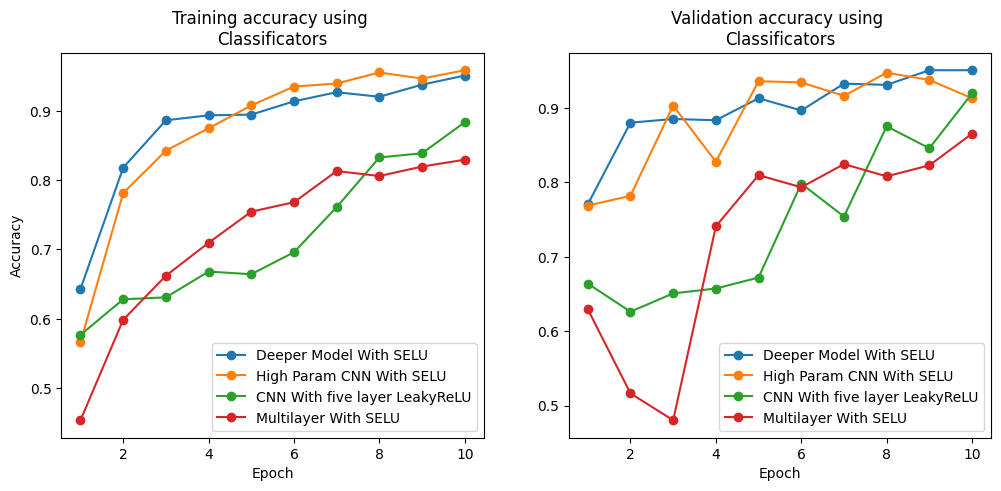

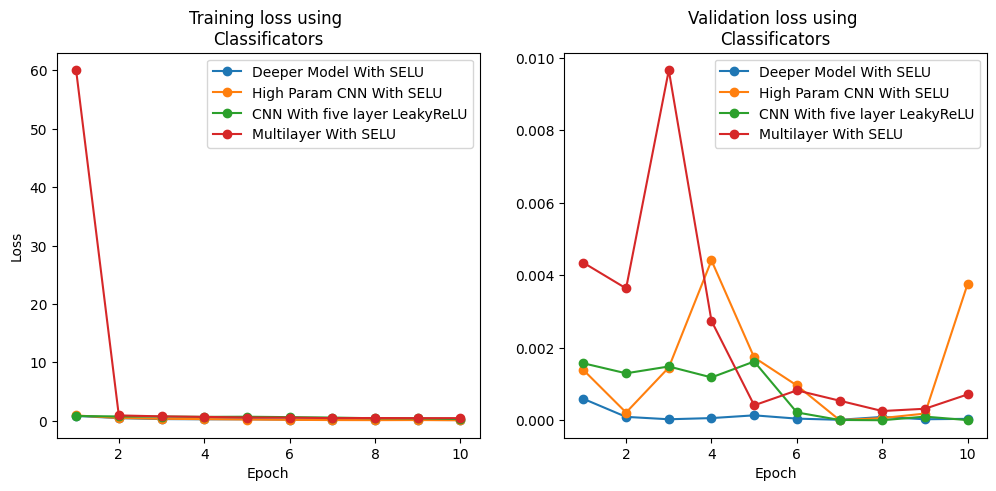

In [20]:
info = {
    'Deeper Model With SELU': deeper_model_with_selu_dic,
    'High Param CNN With SELU': high_param_cnn_with_selu_dic,
    'CNN With five layer LeakyReLU': cnn_with_five_layer_leakyrelu_dic,
    'Multilayer With SELU': multilayer_with_selu_dic
}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss', legend='upper right')